# Введение в рекомендательные системы

План семинара:
1. Теоретическое введение в non-personalized и content-based рекомендательные системы
2. Обсуждение идей построения простых рекомендательных систем
3. Знакомство с данными
4. Построение простейших non-personalized и content-based рекомендательных систем и подсчет HitRate для них
5. Обзор библиотек для построения рекомендательных систем

In [230]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Будем работать с, наверное, самым известым и популярным датасетом для RecSys: **MovieLens**

Ссылка: https://grouplens.org/datasets/movielens/

Датасет представляет из себя набор рейтингов фильмов, а также другую сопутствующую информацию: теги фильмов, ссылки на них на IMDB и тд. Датасеты есть разных размеров, мы поисследуем датасет 2016 года, в нем 20 миллионов оценок, 27000 фильмов и 138000 пользователей. 

In [231]:
!head ml-20m/ratings.csv -n 3

In [232]:
!ls -lh ml-20m/ratings.csv

-rw-r--r-- 1 asaitgalin LD\Domain Users 509M Apr  1  2015 ml-20m/ratings.csv


In [233]:
df = pd.read_csv("ml-20m/ratings.csv")

In [234]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [235]:
!ls ml-20m

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [236]:
!head ml-20m/tags.csv -n 5

In [237]:
!head ml-20m/links.csv -n 5

In [238]:
!head ml-20m/movies.csv -n 5

![Toy story](https://s-media-cache-ak0.pinimg.com/originals/8f/75/4d/8f754d609b06e10a078ed8d3eefcaf04.png)

In [239]:
print("Max user id", df["userId"].max())
print("Max item id", df["movieId"].max())

Max user id 138493
Max item id 131262


In [240]:
print("Unique user count", len(df["userId"].unique()))
print("Unique movie count", len(df["movieId"].unique()))

Unique user count 138493
Unique movie count 26744


Номера фильмов идут не подряд, для удобства перенумеруем фильмы по порядку

In [241]:
index_to_item_id_mapping = [x for x in df["movieId"].sort_values().unique()]
item_id_to_index_mapping = {}
for index, value in enumerate(index_to_item_id_mapping, start=1):
    item_id_to_index_mapping[int(value)] = index

assert len(index_to_item_id_mapping) == 26744

In [242]:
df = pd.DataFrame.from_records(
    {"userId": row.userId, "movieId": item_id_to_index_mapping[int(row.movieId)], "rating": row.rating}
    for row in df.itertuples())

In [243]:
df.shape

(20000263, 3)

Как говорилось на лекции, центральный предмет изучения в рекомендательных системах это матрица user-item.

Разреженность большая: 20000263 / (138493 * 26744) = 0.005

Если восстанавливать ее всю, то это ~ 138493 x 26744 x 4 (размер float) = 13 gb.

In [262]:
def run_cv(predictor_class, fold_count=5, top_size=10):
    users = list(range(len(df["userId"].unique())))
    fold_size = len(users) // fold_count

    results = []

    for fold_start in range(fold_count):
        fold = users[fold_start:fold_start+fold_size]

        df["random"] = np.random.random(size=(df.shape[0], 1))
        idx = df.sort_values(by="random") \
            .reset_index() \
            .groupby("userId") \
            .last()["index"]

        mask = df.index.isin(idx) & df["userId"].isin(fold)
        train_df = df[~mask]
        test_df = df[mask]

        predictor = predictor_class(train_df, test_df)
        
        sum_ = 0.0
        for row in test_df.itertuples():
            prediction = predictor.predict(row)
            if prediction is None:
                continue
                
            sum_ += float(row.movieId in prediction)

        results.append(sum_ / test_df.shape[0])
    
    return np.mean(results)

## Non-personalized рекомендательные системы

Реализуем три метода non-personalized метода рекомендаций:
1. Будем предсказывать топ-10 наиболее популярных фильмов (популярность - число рейтингов)
2. Будем предсказывать топ-10 наиболее рейтинговых фильмов (с самым большим средним рейтингом)
3. Будем предсказывать топ-10 случайных фильмов (каждый раз перемешивая список при предсказании)

Сравним эти методы по метрике HitRate с помощью CV:
$$HR = \frac{\#hits}{\#users}$$

Первый метод, предсказываем топ-10 наиболее популярных фильмов

In [255]:
class PopularityPredictor(object):
    def __init__(self, train_df, test_df):
        self.top = list(train_df
            .groupby("movieId")
            .size()
            .reset_index()
            .sort_values(by=0, ascending=False)
            .iloc[:top_size]["movieId"]
            .values)

    def predict(self, row):
        return self.top

run_cv(PopularityPredictor)

0.050863225184100726

Второй метод, предсказываем топ-10 фильмов с наибольшим средним рейтингом

In [256]:
class AvgRatingPredictor(object):
    def __init__(self, train_df, test_df):
        group_sizes = train_df.groupby("movieId").size().reset_index()
        blacklist = group_sizes[group_sizes[0] < 5].movieId
        train_df = train_df[~train_df.movieId.isin(blacklist)]
    
        self.top = list(train_df
            .groupby("movieId")
            .mean()
            .reset_index()
            .sort_values(by="rating", ascending=False)
            .iloc[:top_size]["movieId"]
            .values)
    
    def predict(self, row):
        return self.top

run_cv(AvgRatingPredictor)

0.013437892931673395

Третий метод, предсказываем случайные 10 фильмов

In [260]:
class RandomPredictor(object):
    def __init__(self, train_df, test_df):
        self.movies = list(range(len(train_df["movieId"].unique())))
    
    def predict(self, row):
        np.random.shuffle(self.movies)
        return self.movies[:10]

run_cv(RandomPredictor)

0.00039714371622441943

## Content-based рекомендательные системы

Будем использовать информацию о фильмах для предсказания, а именно - жанр фильмов.
1. Посмотрим на самые популярные жанры
2. Внутри каждого жанра найдем топ-10 самых популярных фильмов
3. Для каждого пользователя определим топ-3 жанров, которые он смотрит
4. Построим простую content-based систему, предсказывая для каждого пользователя 5 самых популярных фильмов из первого по популярности жанра, 3 фильма второго по популярности жанра и 2 фильма из третьего по популярности жанра
5. Посчитаем HitRate

In [100]:
df_movie = pd.read_csv("ml-20m/movies.csv")

In [110]:
from collections import Counter

genres = []

for row in df_movie.itertuples():
    genre_list = row.genres.split("|")
    genres.extend(genre_list)

cntr = Counter(genres)

In [111]:
cntr

Counter({'(no genres listed)': 246,
         'Action': 3520,
         'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Crime': 2939,
         'Documentary': 2471,
         'Drama': 13344,
         'Fantasy': 1412,
         'Film-Noir': 330,
         'Horror': 2611,
         'IMAX': 196,
         'Musical': 1036,
         'Mystery': 1514,
         'Romance': 4127,
         'Sci-Fi': 1743,
         'Thriller': 4178,
         'War': 1194,
         'Western': 676})

In [113]:
cntr.most_common(5)

[('Drama', 13344),
 ('Comedy', 8374),
 ('Thriller', 4178),
 ('Romance', 4127),
 ('Action', 3520)]

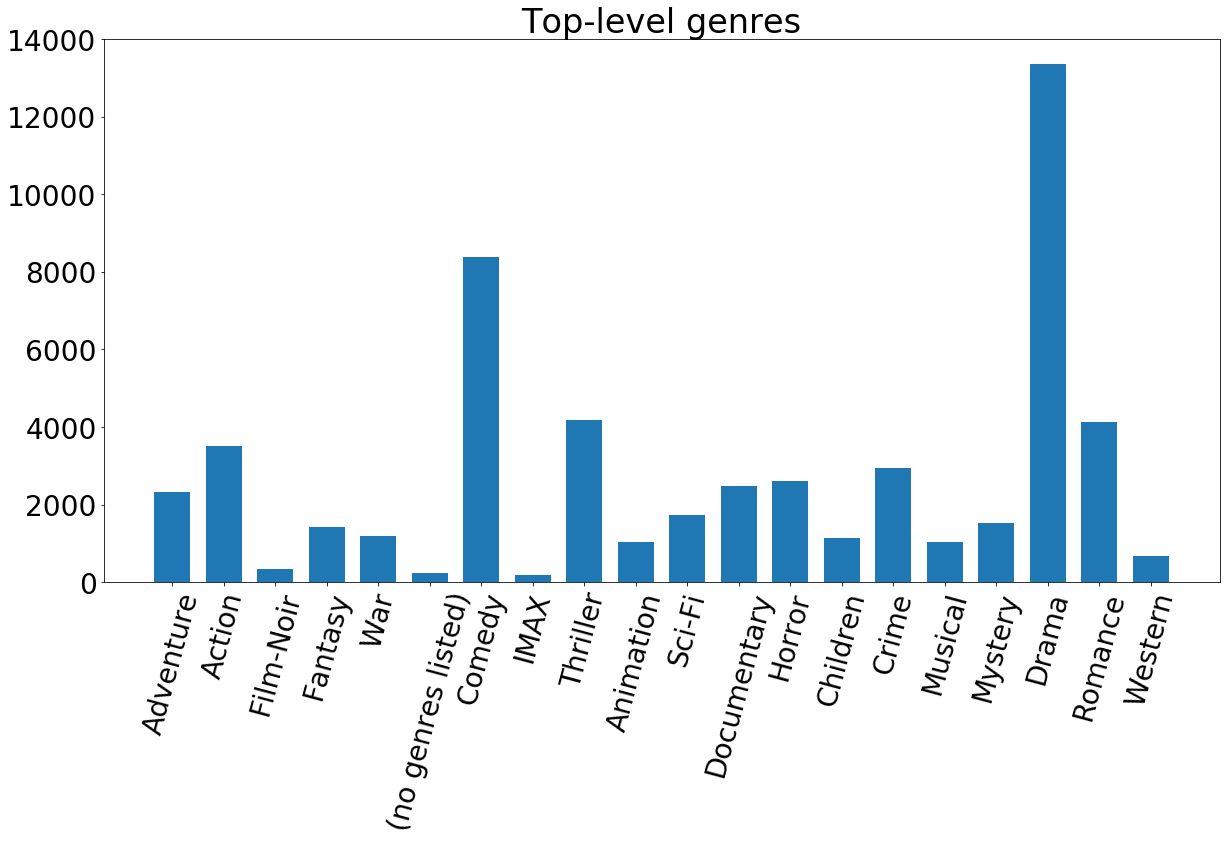

In [126]:
import matplotlib

matplotlib.rcParams.update({'font.size': 28})


plt.figure(figsize=(20,10))
hist, bins = np.histogram(list(cntr.values()), bins=len(cntr))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, cntr.values(), align='center', width=width, tick_label=list(cntr.keys()))
plt.xticks(rotation=75)
_ = plt.title('Top-level genres')

In [145]:
df_joined = pd.merge(df, df_movie[["movieId", "genres"]], on="movieId", how="inner")

In [264]:
def genre_list(x):
    return list(set("|".join(x.tolist()).split("|")))

def genre_list_len(x):
    return len(genre_list(x))

def popular_genres(x):
    return Counter("|".join(x.tolist()).split("|")).most_common(3)

df_users = df_joined.groupby('userId').agg({'genres': [genre_list, genre_list_len, popular_genres]})

In [265]:
df_users.head()

genres                 \
                                               genre_list genre_list_len   
userId                                                                     
1       [Adventure, Action, Fantasy, Comedy, IMAX, Thr...             19   
2       [Adventure, Action, Fantasy, Comedy, Thriller,...             17   
3       [Adventure, Action, Fantasy, Comedy, Romance, ...             18   
4       [Adventure, Action, Fantasy, Comedy, IMAX, Thr...             16   
5       [Adventure, Action, Fantasy, Comedy, IMAX, Thr...             17   

                                                     
                                     popular_genres  
userId                                               
1        [(Drama, 77), (Comedy, 49), (Romance, 31)]  
2       [(Drama, 34), (Comedy, 21), (Thriller, 13)]  
3       [(Drama, 94), (Comedy, 55), (Thriller, 40)]  
4           [(Drama, 13), (Action, 8), (Comedy, 8)]  
5        [(Drama, 39), (Comedy, 25), (Romance, 16)]

Таким образом мы получили для каждого пользователя топ-3 его жанров.

In [266]:
df_joined[df_joined["userId"] == 1].head()  # Sanity-check, что join отработал верно

,movieId,rating,userId,random,genres
0,2,3.5,1,0.699968,Adventure|Children|Fantasy
22243,29,3.5,1,0.353111,Adventure|Drama|Fantasy|Mystery|Sci-Fi
30763,32,3.5,1,0.988698,Mystery|Sci-Fi|Thriller
75743,47,3.5,1,0.936680,Mystery|Thriller
118992,50,3.5,1,0.060261,Crime|Mystery|Thriller


In [172]:
df_counts = df_joined.groupby("movieId").count().reset_index()
df_counts["count"] = df_counts["rating"]
for col in ("userId", "random", "genres", "rating"):
    del df_counts[col]

In [176]:
result = pd.merge(df_joined, df_counts, on="movieId")

In [177]:
result.head()

,movieId,rating,userId,random,genres,count
0,2,3.5,1,0.699968,Adventure|Children|Fantasy,22243
1,2,3.0,5,0.318093,Adventure|Children|Fantasy,22243
2,2,3.0,13,0.569927,Adventure|Children|Fantasy,22243
3,2,3.0,29,0.893119,Adventure|Children|Fantasy,22243
4,2,3.0,34,0.533717,Adventure|Children|Fantasy,22243


count везде одинаков, так и должно быть, так как movieId одинаков (это число оценок у фильма).

In [180]:
genre_to_movies = defaultdict(set)

for row in result.itertuples():
    genres = row.genres.split("|")
    for genre in genres:
        genre_to_movies[genre].add((row.movieId, row.count))

In [185]:
genre_to_top_movies = {}

for k, v in genre_to_movies.items():
    genre_to_top_movies[k] = sorted(list(v), key=lambda p: -p[1])[:10]

In [269]:
df_users_new = df_users.reset_index()

In [270]:
class ContentBasedPredictor(object):
    def __init__(self, train_df, test_df):
        pass
    
    def predict(self, row):
        top = list(df_users_new[df_users_new["userId"] == row.userId][("genres", "popular_genres")])
        
        if not top:
            return
        
        top_genres = [k for k, _ in top[0]]
        recommendations = []
        
        i_to_size = {0: 5, 1: 3, 2: 2}
        for i, genre in enumerate(top_genres):
            for movie, _ in genre_to_top_movies[genre][:i_to_size[i]]:
                recommendations.append(movie)
        
        return recommendations
    
run_cv(ContentBasedPredictor)

0.043570237871631057

## Обзор библиотек для построения рекомендательных систем

a. https://docs.scipy.org/doc/scipy/reference/sparse.html
  
  scipy.sparse и scipy.sparse.linalg.svds :)
Можно делать коллаборативную фильтрацию подсчитывая svd разложение на разреженных матричках. Примеров в интернете полно, про сам метод будет рассказано на лекциях.


b. http://mendeley.github.io/mrec/

  Умеет подготавливать выборку, умеет считать разные популярные метрики такие как HitRate, Recall. Набор стандартных алгоритмов:
  1. kNN (user/item based)
  2. popularity
  3. SLIM, WARP, WRMF


c. http://libfm.org/

 Эффективная реализация модели факторизационных машин. Алгоритмы SGD, ALS.


d. GraphLab Collaborative Filtering Toolkit (https://turi.com/products/create/docs/graphlab.toolkits.recommender.html)

  Умеет SVD (ALS, SGD), SVD++, Weighted-ALS, non-negative matrix factorization.


e. Vowpal Wabbit (https://github.com/JohnLangford/vowpal_wabbit/wiki/Matrix-factorization-example)

Можно использовать разложение матрички оттуда.

## Заключение

1. Познакомились с датасетом MovieLens
2. Построили несколько простых моделей для рекомендаций
3. Познакомились с распространенными библиотеками для построения рекомендательных систем

Обратная связь и ДЗ: https://goo.gl/forms/7tyfXQHSOPHRf5Gg1